## 2 Goal Oriented Risk Management

1. VaR for Normal Distribution<br>
Value at Risk (VaR) measure helps to apply it to a known distribution. 
The Normal (or Gaussian) distribution is especially appealing as it 1) has an analytically simple form, and 2) represents a wide variety of empirical phenomena. For this exercise you'll assume that the loss of a portfolio is normally distributed, i.e., the higher the value drawn from the distribution, the higher the loss.

95% VaR:  1.6448536269514722 ; 99% VaR:  2.317206625242927


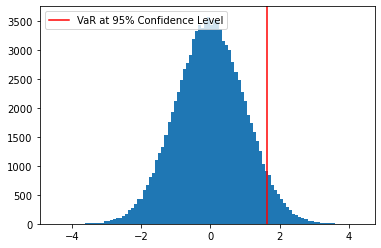

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy import stats
from scipy.stats import norm
from scipy.stats import gaussian_kde
import pandas_datareader as web

# Create the VaR measure at the 95% confidence level using norm.ppf()
VaR_95 = norm.ppf(0.95)

# Create the VaR measure at the 1% significance level using numpy.quantile()
draws = norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend(); plt.show()

Import Data

In [77]:
#  Assets to be included in the portfolio
tickers = ['C', 'MS', 'GS', 'JPM']
portfolio = web.get_data_yahoo(tickers, start = '2005-01-02',end = '2010-12-30')
portfolio = portfolio['Adj Close']
# Ensure the prices are sorted by Date
portfolio = portfolio.sort_values(by='Date')

In [78]:
# Calculate daily returns of stocks
portfolio_returns=portfolio.pct_change().dropna()
# Compute (4 banks equal weights) returns for 2005-2010
weights= [0.25, 0.25, 0.25, 0.25]
portfolio_losses=portfolio_returns@weights
print(portfolio_losses)

Date
2005-01-04   -0.009003
2005-01-05    0.001081
2005-01-06    0.013209
2005-01-07   -0.005479
2005-01-10   -0.002007
                ...   
2010-12-23   -0.005974
2010-12-27    0.012551
2010-12-28    0.000594
2010-12-29   -0.007729
2010-12-30   -0.000818
Length: 1509, dtype: float64


2. Compating VaR and CVaR <br>

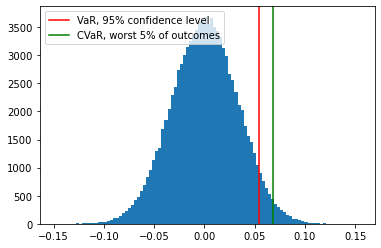

VaR_95: 0.054716781740658665 CVaR_95: 0.06851039297392884


In [79]:
#The conditional value at risk (CVaR), or expected shortfall (ES), asks what the average loss will be, 
#conditional upon losses exceeding some threshold at a certain confidence level. 
#It uses VaR as a point of departure, but contains more information because 
#it takes into consideration the tail of the loss distribution.

# Compute the mean and variance of the portfolio returns
pm = portfolio_losses.mean()
ps = portfolio_losses.std()

# Compute the 95% VaR using the .ppf()
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
# CVaR= 1/(1 / (1 - qunatile))*integral(x*f(x))|lb=quantile
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()
print('VaR_95:', VaR_95, 'CVaR_95:', CVaR_95)

3. VaR and CVaR Risk exposure

In [80]:
# Import the Student's t-distribution
from scipy.stats import t
losses=portfolio_losses
print(losses)
print(losses.shape)

Date
2005-01-04   -0.009003
2005-01-05    0.001081
2005-01-06    0.013209
2005-01-07   -0.005479
2005-01-10   -0.002007
                ...   
2010-12-23   -0.005974
2010-12-27    0.012551
2010-12-28    0.000594
2010-12-29   -0.007729
2010-12-30   -0.000818
Length: 1509, dtype: float64
(1509,)


C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2016: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


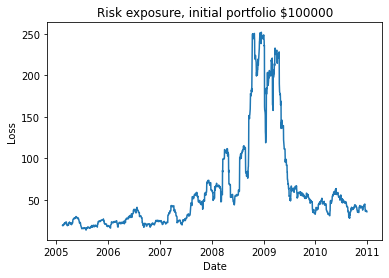

In [81]:
# Create rolling window parameter list
mu = losses.rolling(30).mean()
sigma = losses.rolling(30).std()
rolling_parameters = np.array([(29, mu[i], s) for i,s in enumerate(sigma)])
#print(sigma)
#print(rolling_parameters)
# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters] )
# Plot the minimum risk exposure over the 2005-2010 time period
# risk exposure is the probability of loss (this is 1%) multiplied by the loss amount (this is the loss given by the 99% VaR).
plt.plot(losses.index, 0.01 * VaR_99 * 100000)
plt.xlabel('Date')
plt.ylabel('Loss')
plt.title('Risk exposure, initial portfolio $100000')
plt.show()

4. CVaR and risk exposure <br>

CVaR is the expected value of loss given a minimum loss threshold. So CVaR is already in the form of a risk exposure--it is the sum (or integral) of the probability of loss in the distribution tail multiplied, by the loss amount.
To derive the 99% CVaR, first fit a T distribution to available crisis_losses portfolio data from 2008 - 2009, using the t.fit() method. This returns the T distribution parameters p used to find the VaR with the .ppf() method.
Next compute the 99% VaR, since it's used to find the CVaR.
Finally compute the 99% CVaR measure using the t.expect() method, which is the same method you used to compute CVaR for the Normal distribution in an earlier exercise.

In [82]:
# Fit the Student's t distribution to crisis losses
p = t.fit(losses['2008-01-01':'2009-12-31'])
print(p)
# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

(2.079624172414303, -0.002316115606458178, 0.02594539334442312)
0.33199751733209226


5. VaR from a fitted distribution <br>

Minimizing CVaR requires calculating the VaR at a confidence level, say 95%. Previously you derived the VaR as a quantile from a Normal (or Gaussian) distribution, but minimizing the CVaR more generally requires computing the quantile from a distribution that best fits the data.

In this exercise a fitted loss distribution is provided, which fits losses from an equal-weighted investment bank portfolio from 2005-2010. You'll first plot this distribution using its .evaluate() method.

Next use the .resample() method of the fitted object to draw a random sample of 100,000 observations from the fitted distribution.

Finally, using np.quantile() on the random sample will then compute the 95% VaR.

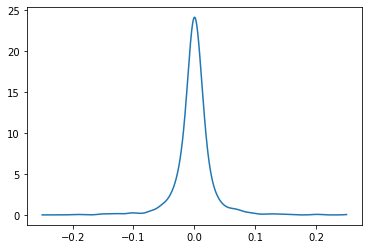

0.04264630376100386


In [223]:
# Fit the kernel-density estimate pdf distribution to crisis losses
fitted = stats.gaussian_kde(losses['2005-01-01':'2010-12-31'])
# Visualize the fitted distribution with a plot
x = np.linspace(-0.25,0.25,1000)
plt.plot(x,fitted.evaluate(x))
plt.show()

# Create a random sample of 100,000 observations from the fitted distribution
sample = fitted.resample(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, 0.95)
print(VaR_95)

6. Minimizing CVaR <br>

This exercise will give you practice with PyPortfolioOpt's tools for CVaR minimization as a risk management objective.

You'll load the pypfopt.efficient_frontier module and retrieve the EfficientFrontier class, creating an instance of the class using the investment bank assets over the 2005 - 2010 period. You'll also load the negative_cvar() function from the pypfopt.objective_functions module.

You'll then use the EfficientFrontier.custom_objective() method with negative_cvar() to find the optimal portfolio weights that minimize the CVaR.

Portfolio asset returns are in the returns vector, and the efficient covariance matrix is in e_cov.

In [225]:
# Import the EfficientFrontier class
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from scipy import integrate

In [226]:
#Lets apply integration for kde gaussian kde function
def cvar_integ_func(kde, x1, quant):

    def f_kde(x):
        return x*kde(x)

    cvar = (1 / (1 - quant))*integrate.quad(f_kde, x1, np.inf)[0]

    return cvar

In [252]:
#Use the fitted parameters and VaR_95 to compute CVaR_95
CVaR_95_KDE = cvar_integ_func(fitted, VaR_95, 0.95)

print(CVaR_95_KDE)

0.08613264520311265


In [253]:
e_cov = CovarianceShrinkage(portfolio).ledoit_wolf()

In [257]:
# Create the efficient frontier instance
#ef = EfficientFrontier(None, e_cov)
exp_ret=np.array(portfolio_returns.max())
ef=EfficientFrontier(exp_ret, e_cov)
# Find the cVar-minimizing portfolio weights at the default 95% confidence level
#optimal_weights = ef.custom_objective(CVaR_95, returns)
optimal_weights=ef.min_volatility()
# Display the optimal weights
print(ef.min_volatility())

OrderedDict([('C', 0.0), ('MS', 0.0), ('GS', 0.6284669377116536), ('JPM', 0.3715330622883464)])


7. Black-Scholes options pricing <br>

Options are the world's most widely used derivative to help manage asset price risk. In this exercise we'll price a European call option on Citibank stock using the Black-Scholes option pricing formula.

First compute the volatility sigma of Citibank returns, as the annualized standard deviation.

Next use the function black_scholes(), created for this and the following exercises, to price options for two different volatility levels: sigma and two times sigma.

The strike price K, i.e. the price an investor has the right (but not the obligation) to buy Citibank, is initial price at 01-jan-2005. The risk-free interest rate r is 2% and the market spot price S is latest price at 31-dec-2006, it has risen during 2 year period.

In [155]:
#lets define black scholes function
#Source code https://aaronschlegel.me/black-scholes-formula-python.html

def black_scholes(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [198]:
#lets use citi returns before crisis
citi_before=portfolio['C']['2005-01-01':'2006-06-30']
citi_returns=citi_before.pct_change().dropna()

# Compute the volatility as the annualized standard deviation of Citi returns
sigma = np.sqrt(252) * citi_returns.std()

citi=portfolio['C']['2006-07-01':'2007-01-01']
#print(citi.head(1))
#strike price
citi_x=citi.head(1)
#spot_price
citi_s=citi.tail(1)
print(citi_x)
print(citi_s)
#pass only value without index to scholes fromula below
citi_x=citi_x.to_numpy()
citi_s=citi_s.to_numpy()

Date
2006-07-03    385.028656
Name: C, dtype: float64
Date
2006-12-29    446.763458
Name: C, dtype: float64


In [199]:
# Compute the Black-Scholes option price for this volatility
value_s = black_scholes(S = citi_s[0], K = citi_x[0], T = 0.5, r = 0.02, 
                        sigma = sigma, option = "call")

# Compute the Black-Scholes option price for twice the volatility
value_2s = black_scholes(S = citi_s[0], K = citi_x[0], T = 0.5, r = 0.02, 
                sigma = 2*sigma, option = "call")

# Display and compare both values
print("Option value for sigma: ", value_s, "\n",
      "Option value for 2 * sigma: ", value_2s)

Option value for sigma:  66.29964279731769 
 Option value for 2 * sigma:  74.19128141008872


8. Options pricing and the underlying asset

Options are essentially bets on the future evolution of the underlying asset's price.

For example, a put option is valuable when the spot (market) price falls below the option's strike price. The option holder may exercise the option to sell the underlying at the strike X, and buy it back at the spot S < X, yielding profit X-S.

In this exercise you'll value and visualize a European put option on Citibank stock, again applying the Black-Scholes pricing formula, as the spot S changes.

The strike X = 140, the time to maturity T is 1/2 a year, and the risk-free interest rate is 2%.

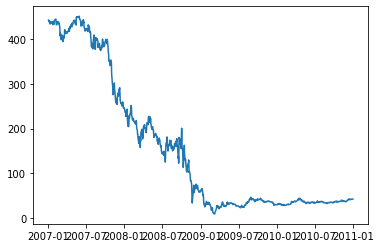

In [200]:
citi=portfolio['C']['2007-01-01':]
plt.plot(citi)
plt.show()
citi_x=portfolio['C']['2007-01-01':].max()
citi=np.array(citi)

In [201]:
# Select the first 100 observations of Citi data
#IBM_spot = IBM[:100]

# Initialize the European put option values array
option_values = np.zeros(citi.size)

# Iterate through IBM's spot price and compute the option values
for i,S in enumerate(citi):
    option_values[i] = black_scholes(S = S, K = citi_x, T = 0.5, r = 0.02, 
                        sigma = sigma, option = "put")

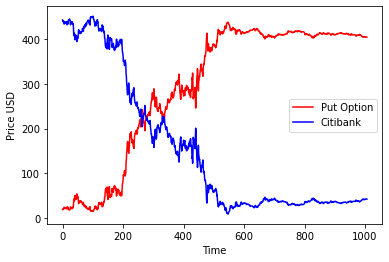

In [202]:
# Display the option values
plt.plot(option_values, color = "red", label = "Put Option")
plt.plot(citi, color = "blue", label = "Citibank")
plt.legend(loc = "center right")
plt.ylabel('Price USD')
plt.xlabel('Time')
plt.show()

9.Using options for hedging

Suppose that you have an investment portfolio with one asset. You'll hedge the portfolio's risk using delta hedging with a European put option on this asset.

First, value the European put option using the Black-Scholes option pricing formula, with a strike X of 80 and a time to maturity T of 1/2 a year. The risk-free interest rate is 2% and the spot S is initially 70.

Then create a delta hedge by computing the delta of the option with the bs_delta() function, and use it to hedge against a change in the stock price to 69.5. The result is a delta neutral portfolio of both the option and the stock.

In [ ]:
# Compute the annualized standard deviation of `IBM` returns
sigma = np.sqrt(252) * IBM_returns.std()

# Compute the Black-Scholes value at IBM spot price 70
value = black_scholes(S = 70, X = 80, T = 0.5, r = 0.02, 
                      sigma = sigma, option_type = "put")
# Find the delta of the option at IBM spot price 70
delta = bs_delta(S = 70, X = 80, T = 0.5, r = 0.02, 
                 sigma = sigma, option_type = "put")

# Find the option value change when the price of IBM falls to 69.5
value_change = black_scholes(S = 69.5, X = 80, T = 0.5, r = 0.02, 
                             sigma = sigma, option_type = "put") - value

print( (69.5 - 70) + (1/delta) * value_change )